In [1]:
# Import packages

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils
import wf_psf.script_utils as wf_script_utils

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


# Metrics

In [2]:
metrics_file = '../wf-outputs/metrics/metrics-poly_%s_cycles_256_%s_d%s_%sz.npy'
dataset_list = [('2', 'no_proj', '2', '45'),('2', 'no_proj', '2', '60'),('5', 'no_proj', '2', '45'),('5', 'proj', '2', '45'),('5', 'proj', '2', '60'),('5', 'proj', '5', '45'),('9', 'no_proj', '2', '45'),('9', 'proj', '2', '45')]


In [3]:
metrics_dict_list = wf_script_utils.extract_shape_pix_results([np.load(metrics_file % dataset, allow_pickle=True)[()] for dataset in dataset_list ])

In [4]:
print('n cycles | project | d_max param | n_zernike      SR RMSE\n')
for idx, dataset in enumerate(dataset_list):
    print('%s cycles - %s - d_max=%s - %sz' % dataset, ' ---> ', metrics_dict_list[2][idx])

n cycles | project | d_max param | n_zernike      SR RMSE

2 cycles - no_proj - d_max=2 - 45z  --->  2.0841412246227264
2 cycles - no_proj - d_max=2 - 60z  --->  2.8755173087120056
5 cycles - no_proj - d_max=2 - 45z  --->  2.2564904764294624
5 cycles - proj - d_max=2 - 45z  --->  3.0819714069366455
5 cycles - proj - d_max=2 - 60z  --->  4.889374598860741
5 cycles - proj - d_max=5 - 45z  --->  4.327797889709473
9 cycles - no_proj - d_max=2 - 45z  --->  4.043024033308029
9 cycles - proj - d_max=2 - 45z  --->  3.3228691667318344


# Create model

In [5]:
args = {
    'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/interp_SEDs/',
    #'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/more_stars/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_009_8_bins_sigma_0.npy',
    #'train_dataset_file': 'train_Euclid_res_3000_TrainStars_id_008_wfeRes_128.npy',
    'test_dataset_file': 'test_Euclid_res_id_009_8_bins.npy',
    #'test_dataset_file': 'test_Euclid_res_id_008_wfeRes_128.npy',
    'n_zernikes': 45,
    'pupil_diameter': 256,
    #'pupil_diameter': 128,
    'n_bins_lda':8,
    #'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'chkp_save_path':'../wf-outputs/chkp/8_bins/chkp_callback_poly_9_cycles_256_proj_d2_45z_cycle',
    #'chkp_save_path':'../wf-outputs/chkp/8_bins/chkp_callback_poly_%s_cycles_256_%s_d%s_%sz_cycle',
    }

In [6]:
## Prepare the inputs
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(
    n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)

Zernike cube:
(45, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


In [7]:
## Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

In [8]:
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )


# Generate WFE 

In [9]:
# Select any star from the 2000 test stars and generate GT WFE
test_star = 188
test_dataset = np.load(args['dataset_folder']+args['test_dataset_file'], allow_pickle=True)[()]
pos = test_dataset['positions'][test_star:test_star+1,:]
param_opd_maps_GT = tf.tensordot(tf_zernike_cube_gt, tf.constant(test_dataset['zernike_coef'][test_star,:,0],dtype=tf.float32), axes=[0,0])


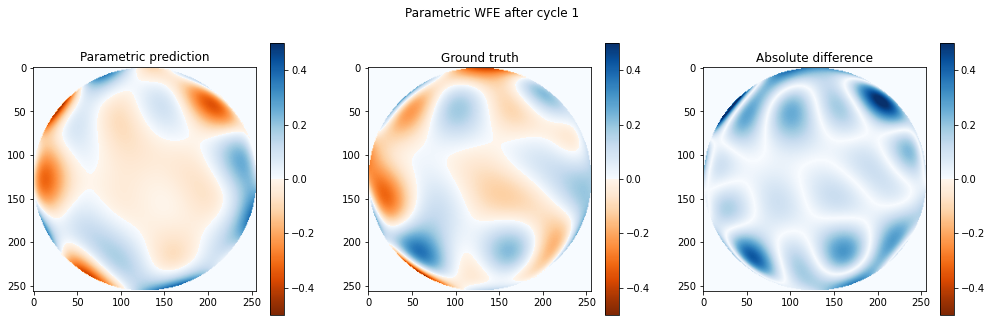

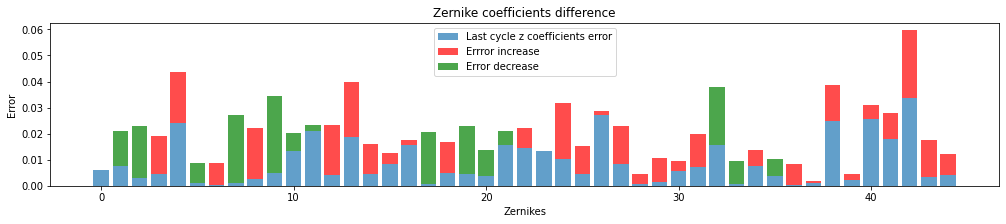

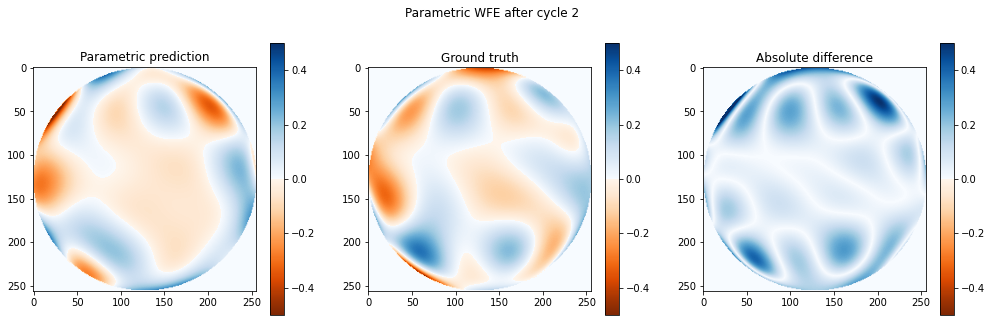

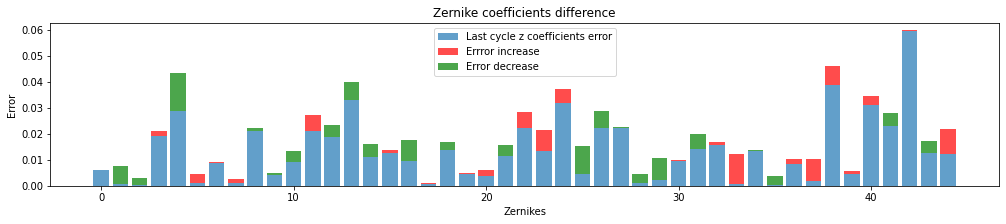

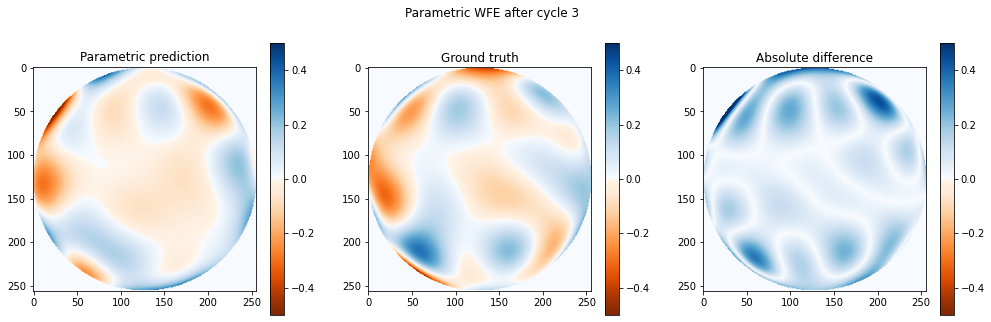

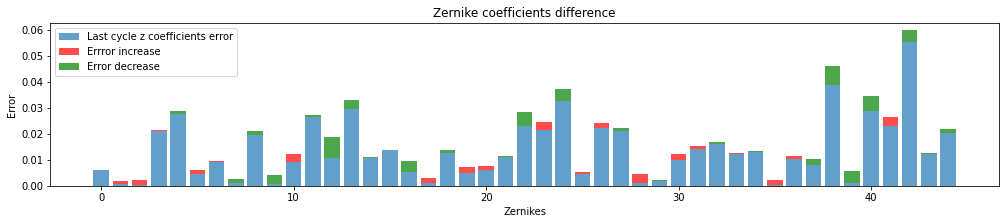

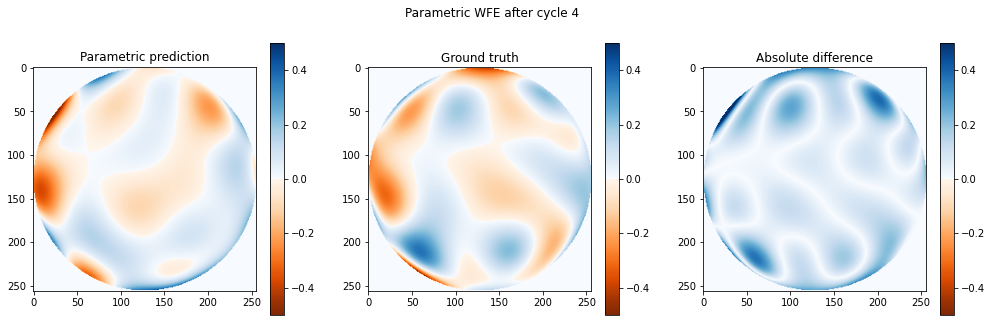

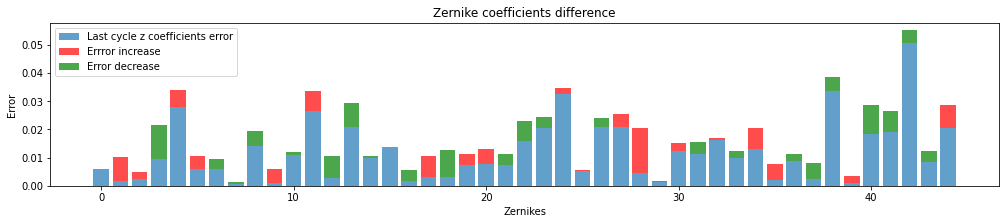

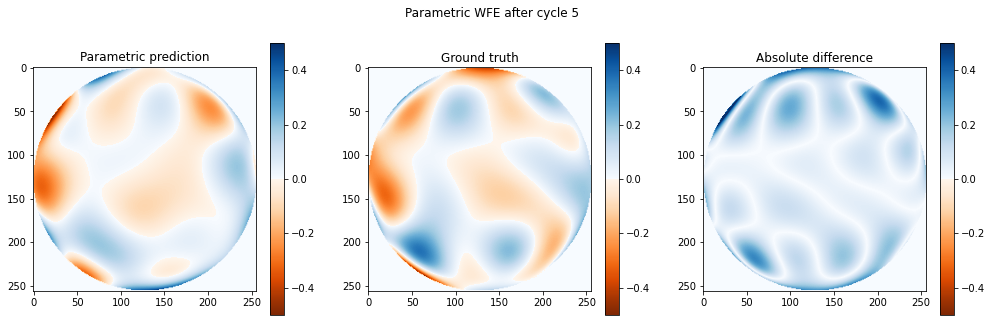

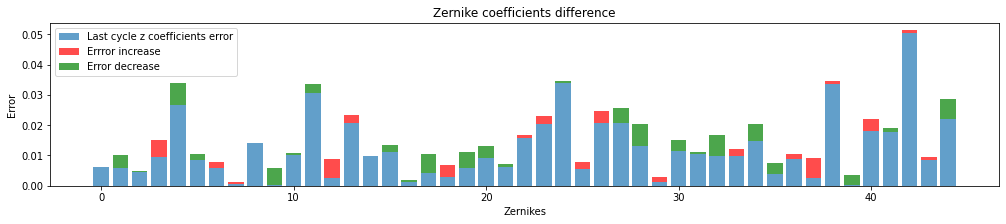

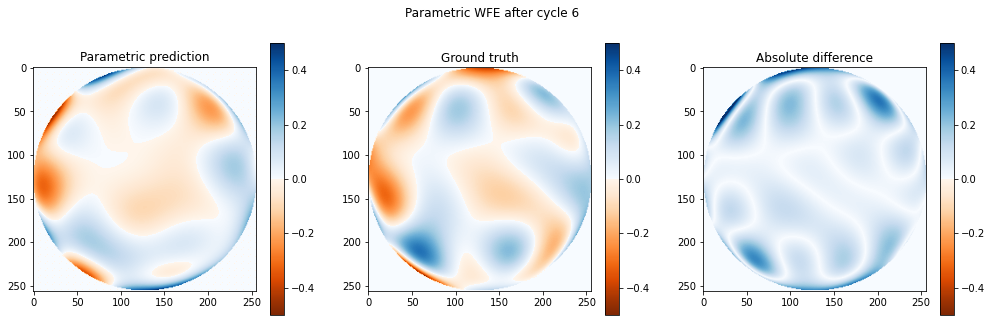

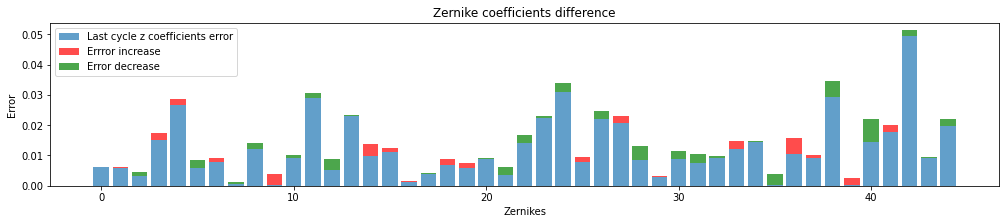

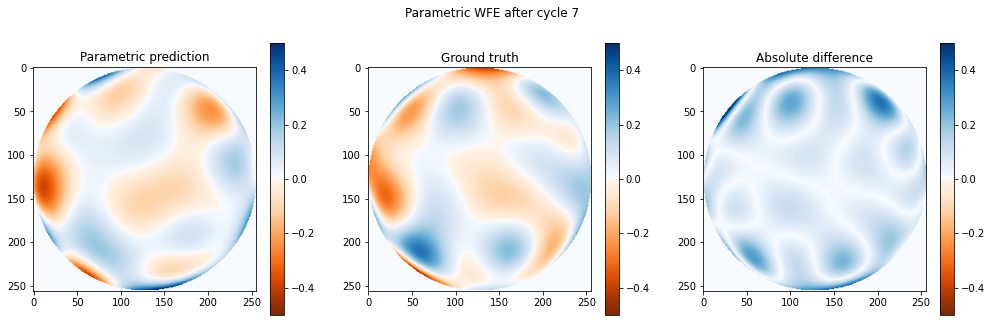

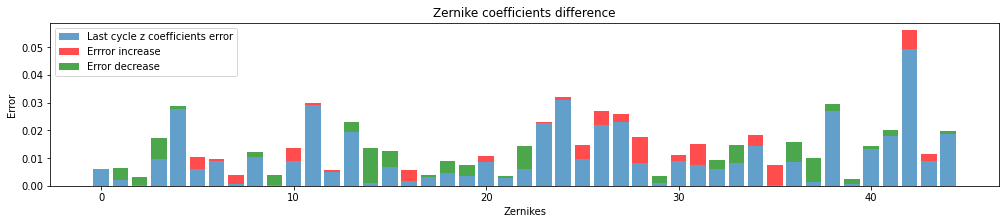

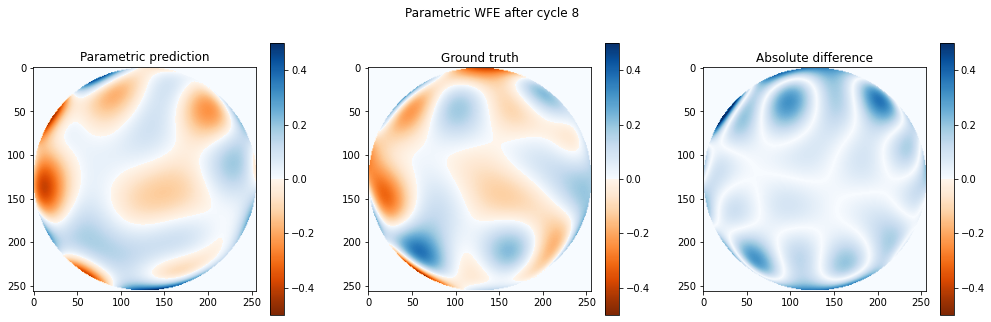

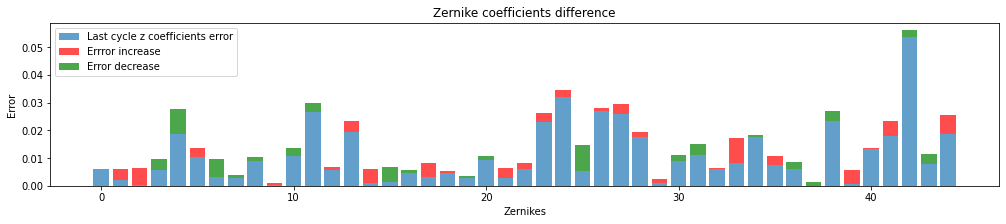

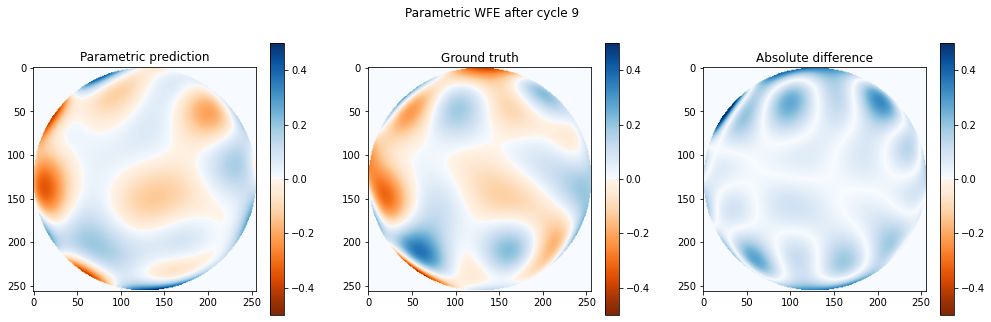

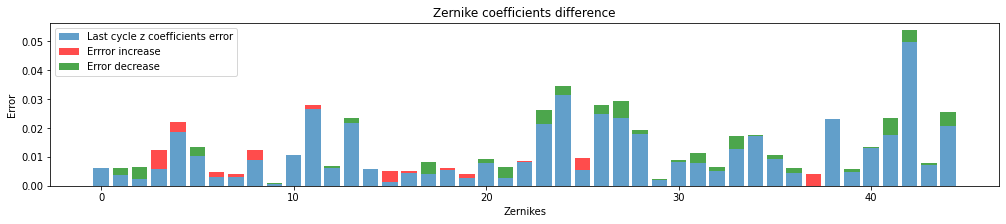

In [10]:
load_cycle = 9
weights_paths = args['chkp_save_path']

zernike_coeffs_last = np.zeros((1,45,1,1))

for cycle_idx in range(load_cycle):
    # Load the model's weights
    tf_semiparam_field.load_weights(weights_paths+str(cycle_idx+1))
    # Parametric WFE
    zernike_coeffs = tf_semiparam_field.tf_poly_Z_field(pos)
    zernike_coeffs=np.array(zernike_coeffs)
    zernike_coeffs[0,0,0,0] = 0
    param_opd_maps = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs)
    
    # Show parametric, non-parametric and total WFE
    fig, ax = plt.subplots(1,3, figsize=(17,5))
    im = ax[0].imshow(param_opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
    ax[0].set_title('Parametric prediction')
    plt.colorbar(im, ax=ax[0])
    im = ax[1].imshow(param_opd_maps_GT, cmap=newcmp, vmax=0.5, vmin=-0.5)
    ax[1].set_title('Ground truth')
    plt.colorbar(im, ax=ax[1])
    im = ax[2].imshow(np.abs(param_opd_maps_GT-param_opd_maps[0,:,:]), cmap=newcmp, vmax=0.5, vmin=-0.5)
    ax[2].set_title('Absolute difference')
    plt.colorbar(im, ax=ax[2])
    fig.suptitle('Parametric WFE after cycle '+str(cycle_idx+1))
    plt.show()

    current_Z_err = np.abs(np.array(zernike_coeffs[0,:,0,0]) - np.array(test_dataset['zernike_coef'][test_star,:,0]))
    last_Z_err = np.abs(np.array(zernike_coeffs_last[0,:,0,0]) - np.array(test_dataset['zernike_coef'][test_star,:,0]))

    plt.figure(figsize=(17,3))
    plt.bar(np.array(range(args['n_zernikes'])), np.minimum(current_Z_err,last_Z_err), alpha=0.7)
    plt.bar(np.array(range(args['n_zernikes'])), np.clip(current_Z_err-last_Z_err,a_min=0, a_max=None), alpha=0.7,bottom=np.minimum(current_Z_err,last_Z_err), color='red')
    plt.bar(np.array(range(args['n_zernikes'])), np.clip(last_Z_err-current_Z_err,a_min=0, a_max=None), alpha=0.7,bottom=np.minimum(current_Z_err,last_Z_err), color='green')
    #plt.bar(np.array(range(args_256['n_zernikes']-1))+1, np.array(z_coefs_256_project_non_param[1:args_256['n_zernikes']]), alpha=0.5, color='tab:green')
    plt.legend(['Last cycle z coefficients error', 'Errror increase', 'Error decrease'])
    plt.title('Zernike coefficients difference')
    plt.xlabel('Zernikes')
    plt.ylabel('Error')
    plt.show()

    zernike_coeffs_last = zernike_coeffs